In [25]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
from itertools import combinations
import pandas as pd
import numpy as np
import mne
from scipy.stats import f_oneway, ttest_ind, false_discovery_control, mannwhitneyu
import pandarallel

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATA_DIR = "/mnt/ernie_main/Price/ephys/data/periconnectivity"
peri_fs = glob.glob(os.path.join(DATA_DIR, "*network*pat*.csv"))
peri_fs = [f for f in peri_fs if ('verbose' not in f)]

In [3]:
## load all net dataframes as grp_peri_dfs

grp_peri_dfs = []
check_list = []
for f in peri_fs:

    peri_df = pd.read_csv(f)
    try:
        peri_event_df = center_onset(peri_df, **{'mid_sz_length':20})
        grp_peri_dfs.append(peri_event_df)
    except IndexError as e:
        print(f) 
        check_list.append(f)
grp_peri_dfs = pd.concat(grp_peri_dfs)

/tmp/ipykernel_97297/1477668667.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_97297/1477668667.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_97297/1477668667.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_97297/1477668667.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_97297/1477668667.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)


## Processing data for plotting and statistics

In [4]:
grp_peri_dfs = grp_peri_dfs[grp_peri_dfs.freq_band == 'alpha']

In [5]:
grp_peri_dfs

,win_label,win_sz_st_end,sz_end,win_sz_centered,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,eventID,patID,sz_type
51954,interictal,-595.0,289,-595,0,soz,0.057941,0.166721,0.108779,alpha,0.0_0.0_0.0,5,Epat06,FIAS
51955,interictal,-595.0,289,-595,0,pz,-0.035211,0.079078,0.114289,alpha,0.0_0.0_0.0,5,Epat06,FIAS
51956,interictal,-595.0,289,-595,0,nz,-0.000732,0.100850,0.101582,alpha,0.0_0.0_0.0,5,Epat06,FIAS
51972,interictal,-594.0,289,-594,1,soz,0.082264,0.192998,0.110733,alpha,0.0_0.0_0.0,5,Epat06,FIAS
51973,interictal,-594.0,289,-594,1,pz,-0.035031,0.078562,0.113593,alpha,0.0_0.0_0.0,5,Epat06,FIAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70153,post_ictal,632.0,188,781,1376,pz,0.062420,0.158100,0.095680,alpha,2.0_2.0_2.0,17,Spat10,"Focal, unknown awareness"
70154,post_ictal,632.0,188,781,1376,nz,-0.007411,0.096652,0.104063,alpha,2.0_2.0_2.0,17,Spat10,"Focal, unknown awareness"
70170,post_ictal,633.0,188,782,1377,soz,0.027670,0.121513,0.093843,alpha,2.0_2.0_2.0,17,Spat10,"Focal, unknown awareness"
70171,post_ictal,633.0,188,782,1377,pz,0.050617,0.145631,0.095015,alpha,2.0_2.0_2.0,17,Spat10,"Focal, unknown awareness"


In [6]:
# Grouping across seizures on a per-patient level
# For every patient, along each region, in each frequency band, for all windows of time per seizure, group and get average values
grp_peri_dfs = grp_peri_dfs.dropna()
agg_df = agg_verbose_df(
    grp_peri_dfs,
    measure_cols=['net_pdc','in_pdc','out_pdc'],
    categorical_cols=['region','patID','win_sz_st_end','eventID','sz_type']
)
peri_stats_df = agg_verbose_df(
    agg_df,
    measure_cols=['net_pdc','in_pdc','out_pdc'],
    categorical_cols=['region','patID','win_sz_st_end','sz_type']
)
peri_stats_df

,region,patID,win_sz_st_end,sz_type,net_pdc,in_pdc,out_pdc
0,nz,Epat02,-595.0,FBTC,-0.000394,0.072635,0.073029
1,nz,Epat02,-595.0,FIAS,-0.003974,0.072253,0.076227
2,nz,Epat02,-594.0,FBTC,-0.000479,0.072250,0.072729
3,nz,Epat02,-594.0,FIAS,-0.004076,0.070455,0.074531
4,nz,Epat02,-593.0,FBTC,-0.000715,0.072115,0.072830
...,...,...,...,...,...,...,...
578598,soz,pat33,629.0,FAS,-0.005008,0.081064,0.086073
578599,soz,pat33,630.0,FAS,0.000545,0.086052,0.085507
578600,soz,pat33,631.0,FAS,-0.001883,0.085848,0.087732
578601,soz,pat33,632.0,FAS,0.010302,0.094184,0.083882


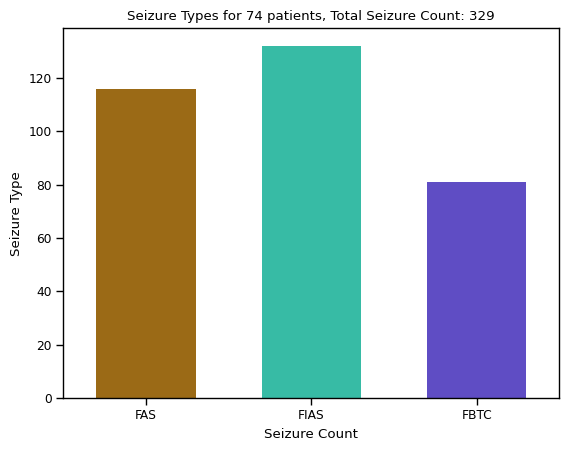

In [7]:
# use non-verbose pipeline
count_df = agg_df[(agg_df.win_sz_st_end == 0) & (agg_df.region == 'nz')]
count_df = count_df[['eventID','patID','sz_type']].groupby(['sz_type']).count().reset_index()
count_df = count_df[count_df.sz_type.isin(['FAS','FIAS','FBTC'])]

n_patients = agg_df.patID.unique().size
total_sz = count_df.eventID.sum()
with sns.plotting_context("paper"):
    ax = sns.barplot(
        count_df, 
        x='sz_type',
        y='eventID', 
        hue="sz_type",
        order=['FAS','FIAS','FBTC'],
        width=0.6,
        palette=COLOR_MAP
    )

    plt.title(f"Seizure Types for {n_patients} patients, Total Seizure Count: {total_sz}")
    plt.xlabel("Seizure Count")
    plt.ylabel("Seizure Type")
    
    plt.savefig("../viz/sz_counts.pdf", format='pdf', transparent=True)

In [8]:
count_df

,sz_type,eventID,patID
0,FAS,116,116
1,FBTC,81,81
2,FIAS,132,132


## Significance testing

In [9]:
# One-way ANOVA at sz_duration timepoints comparing FAS vs. FIAS vs. FBTC

pvals = []

for window in range(0,40):

    anova_df = peri_stats_df[(peri_stats_df.win_sz_st_end == window) & (peri_stats_df.region == 'soz')]
    FAS_data = anova_df.loc[anova_df.sz_type == 'FAS'].net_pdc.to_numpy()
    FIAS_data = anova_df.loc[anova_df.sz_type == 'FIAS'].net_pdc.to_numpy()
    FBTC_data = anova_df.loc[anova_df.sz_type == 'FBTC'].net_pdc.to_numpy()

    pvalue = f_oneway(FAS_data,FIAS_data,FBTC_data).pvalue
    pvals.append(pvalue)

corr_pvals = false_discovery_control(pvals)
is_sig = corr_pvals < 0.01
corr_pvals

array([8.05972828e-01, 9.08227670e-01, 8.27019069e-01, 8.27019069e-01,
       8.27019069e-01, 6.48907942e-01, 6.36026959e-01, 6.23979986e-01,
       5.38504511e-01, 4.77889184e-01, 2.19725897e-01, 2.16264756e-01,
       4.46942773e-01, 6.25534833e-01, 6.25534833e-01, 5.08371154e-01,
       5.38504511e-01, 5.01493893e-01, 6.23979986e-01, 5.01493893e-01,
       4.83393156e-01, 1.05477070e-01, 9.00260383e-03, 1.65462120e-03,
       2.79531595e-03, 1.65462120e-03, 1.15456720e-03, 1.60100502e-03,
       3.44318742e-04, 1.22627328e-04, 6.64615380e-05, 6.64615380e-05,
       6.64615380e-05, 1.56096046e-04, 1.07955974e-03, 1.07955974e-03,
       1.82691118e-03, 4.38328957e-03, 1.69282228e-02, 5.98474029e-01])

In [15]:
sig_windows = (np.where(is_sig == True)[0])
sig_start = np.min(sig_windows)
sig_end = np.max(sig_windows)

# check that all continuous windows are significant for plotting
# TODO: add capability for non-continuous plotting
for i in range(sig_start,sig_end+1):
    assert i in sig_windows

sig_windows

array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37])

In [11]:
# Post-hoc tests for significant window

pvalue_dict = {}

for (a,b) in combinations(['FAS','FIAS','FBTC'], 2):
    anova_df = peri_stats_df[peri_stats_df.region == 'soz']
    anova_df = anova_df.loc[anova_df.win_sz_st_end >= sig_start]
    anova_df = anova_df.loc[anova_df.win_sz_st_end <= sig_end]
    
    a_data = anova_df.loc[anova_df.sz_type == a].net_pdc.to_numpy()
    b_data = anova_df.loc[anova_df.sz_type == b].net_pdc.to_numpy()

    result = ttest_ind(a_data, b_data)
    pvalue_dict[f'{a} vs. {b}'] = result.pvalue, result.statistic

In [12]:
pvalue_dict

{'FAS vs. FIAS': (np.float64(1.7621972183038638e-28),
  np.float64(11.361239420940981)),
 'FAS vs. FBTC': (np.float64(1.2829873558199934e-51),
  np.float64(15.913440938038352)),
 'FIAS vs. FBTC': (np.float64(5.625135372941146e-10),
  np.float64(6.251314300419147))}

In [13]:
# One-way tests for differences in seizure duration

agg_df = agg_verbose_df(
    grp_peri_dfs,
    measure_cols=['sz_end'],
    categorical_cols=['patID','eventID','sz_type']
)
sz_duration_df = agg_verbose_df(
    agg_df,
    measure_cols=['sz_end'],
    categorical_cols=['patID','sz_type']
)

pvalue_dict = {}

for (a,b) in combinations(['FAS','FIAS','FBTC'], 2):
    
    a_data = sz_duration_df.loc[sz_duration_df.sz_type == a].sz_end.to_numpy()
    b_data = sz_duration_df.loc[sz_duration_df.sz_type == b].sz_end.to_numpy()

    result = ttest_ind(a_data, b_data)
    pvalue_dict[f'{a} vs. {b}'] = result.pvalue, result.statistic

FAS_data = sz_duration_df.loc[sz_duration_df.sz_type == 'FAS'].sz_end.to_numpy()
FIAS_data = sz_duration_df.loc[sz_duration_df.sz_type == 'FIAS'].sz_end.to_numpy()
FBTC_data = sz_duration_df.loc[sz_duration_df.sz_type == 'FBTC'].sz_end.to_numpy()

f_oneway(FAS_data,FIAS_data,FBTC_data).pvalue

np.float64(0.6991991908636274)

In [14]:
pvalue_dict

{'FAS vs. FIAS': (np.float64(0.9336111690307429),
  np.float64(-0.08357509021283477)),
 'FAS vs. FBTC': (np.float64(0.4838244436315048),
  np.float64(-0.7037057745571825)),
 'FIAS vs. FBTC': (np.float64(0.42222065106754814),
  np.float64(-0.8067709675865757))}

## Plotting

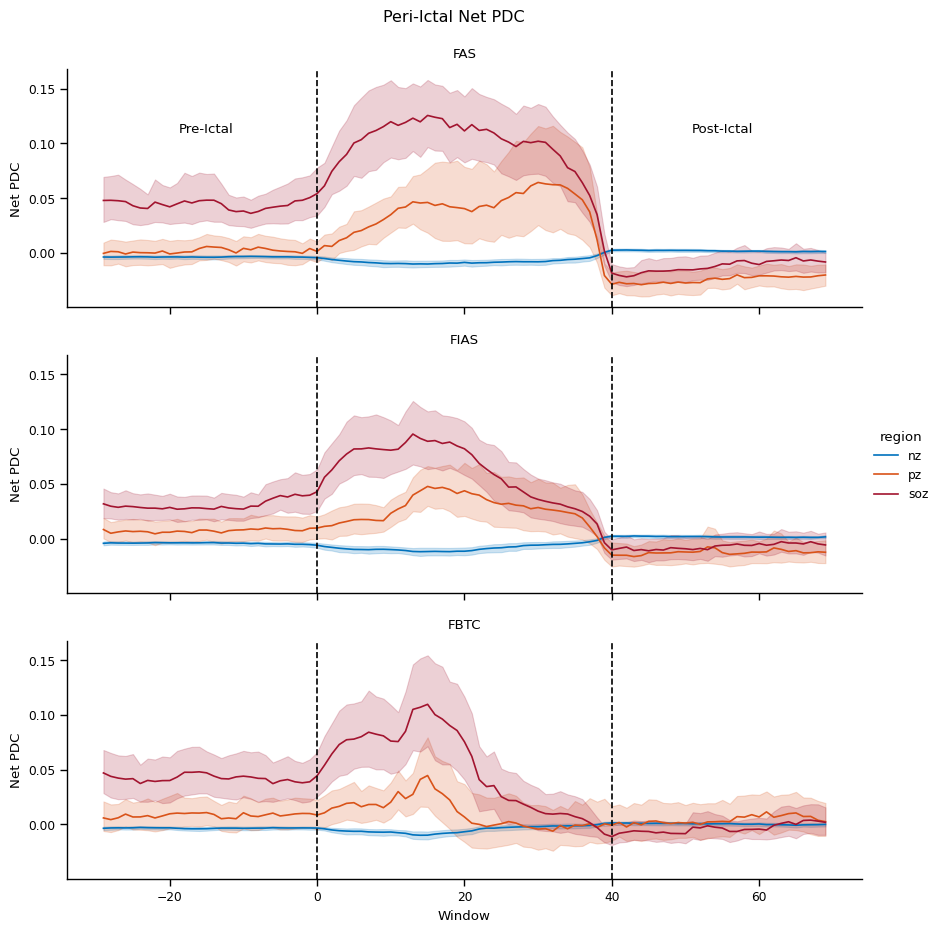

In [18]:
# Net PDC by seizure type

sz_len = 40
xmin = -30
xmax = sz_len + 30
with sns.plotting_context("paper", font_scale=1):
    plot_df = peri_stats_df.copy() # [peri_stats_df.patID == 'Epat03']
    plot_df = plot_df[plot_df.win_sz_st_end > xmin]
    plot_df = plot_df[plot_df.win_sz_st_end < xmax]

    g = sns.relplot(
        data=plot_df, 
        row='sz_type',
        row_order=['FAS','FIAS','FBTC'],
        y='net_pdc',
        x='win_sz_st_end',
        hue='region',
        height=3,
        aspect=3,
        kind='line',
        palette=COLOR_MAP
    )
    
    for ax, sz_type, yval in zip(g.axes.flatten(), ['FAS','FIAS','FBTC'], [0.165,0.13,0.15]):
        # ax.plot([sig_start,sig_end],[yval,yval],c='k',ls='-') # plot significance bars
        # ax.text((sig_start+sig_end)/2, yval+0.003, "**", ha='center', va='bottom', c='k')
        ax.set_ylabel('Net PDC')
        ax.set_title(sz_type, y = 1.015)
        for i in (0,sz_len):
            ax.axvline(i,ls='--',c='k') # plot lines for sz onset and offset
    
    g.axes[0][0].text(x=xmin//2, y=0.11, ha='center', s='Pre-Ictal')
    g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.11, ha='center', s='Post-Ictal')
    g.axes[-1][0].set_xlabel('Window')
    g.figure.suptitle("Peri-Ictal Net PDC",y=1.03)
    plt.subplots_adjust(hspace=0.2)
    
    plt.savefig("../viz/peri_net_pdc_noNorm_sztypes.pdf", format='pdf', transparent=True)


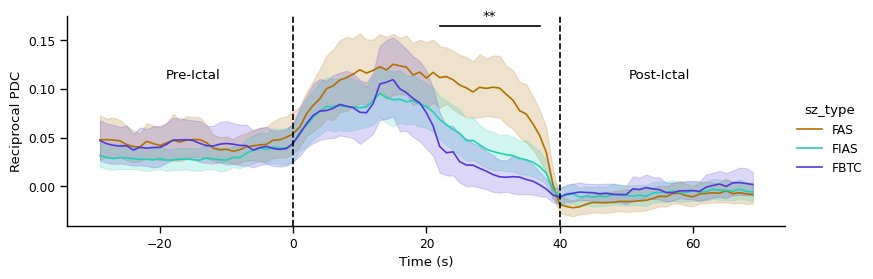

In [24]:
# Net PDC by seizure type

sz_len = 40
xmin = -30
xmax = sz_len + 30
with sns.plotting_context("paper", font_scale=1):
    plot_df = peri_stats_df.copy() # [peri_stats_df.patID == 'Epat03']
    plot_df = plot_df[plot_df.win_sz_st_end > xmin]
    plot_df = plot_df[plot_df.win_sz_st_end < xmax]

    g = sns.relplot(
        data=plot_df, 
        row='region',
        row_order=['soz'],
        y='net_pdc',
        x='win_sz_st_end',
        hue='sz_type',
        hue_order=['FAS','FIAS','FBTC'],
        height=3,
        aspect=2.75,
        kind='line',
        palette=COLOR_MAP
    )
    
    for ax, sz_type, yval in zip(g.axes.flatten(), ['SOZ'], [0.165]):
        ax.plot([sig_start,sig_end],[yval,yval],c='k',ls='-') # plot significance bars
        ax.text((sig_start+sig_end)/2, yval+0.003, "**", ha='center', va='bottom', c='k')
        ax.set_ylabel('Reciprocal PDC')
        ax.set_title('', y = 1.015)
        for i in (0,sz_len):
            ax.axvline(i,ls='--',c='k') # plot lines for sz onset and offset
    
    g.axes[0][0].text(x=xmin//2, y=0.11, ha='center', s='Pre-Ictal')
    g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.11, ha='center', s='Post-Ictal')
    g.axes[-1][0].set_xlabel('Time (s)')
    # g.figure.suptitle("Peri-Ictal Net PDC",y=1.03)
    
    plt.savefig("../viz/peri_net_pdc_soz_sztypes.pdf", bbox_inches='tight', format='pdf', transparent=True)
    plt.savefig("../viz/peri_net_pdc_soz_sztypes.svg", bbox_inches='tight', format='svg', transparent=True)

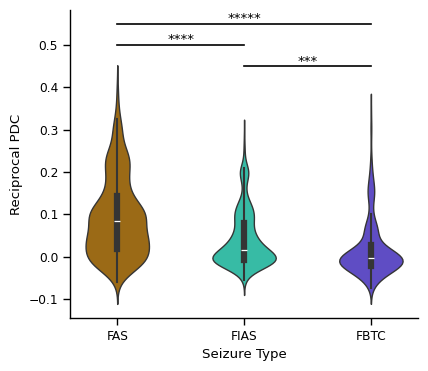

In [21]:
# Plot violin plot of net PDC during significant range

sz_len = 40

with sns.plotting_context("paper", font_scale=1):
    plot_df = peri_stats_df.copy()
    plot_df = plot_df.loc[plot_df.region == 'soz']
    plot_df = plot_df[plot_df.win_sz_st_end >= sig_start]
    plot_df = plot_df[plot_df.win_sz_st_end <= sig_end]
    plot_df = plot_df[plot_df.sz_type.isin(('FAS','FIAS','FBTC'))]

    fig, ax = plt.subplots()
    fig.set_size_inches(4.5,4)

    g = sns.violinplot(
        data=plot_df, 
        x='sz_type',
        y='net_pdc',
        order=['FAS','FIAS','FBTC'],
        hue='sz_type',
        ax=ax,
        width=0.5,
        palette={
            'FAS': '#B17000',
            'FIAS': '#21D1B3',
            'FBTC': '#5139D8'
        }
        # palette=REDS
    )

    for [x1,x2,y],n in zip(([0,2,0.55],[0,1,0.5],[1,2,0.45]),(5,4,3)):
        plt.plot([x1,x2],[y,y],c='k',ls='-') # plot significance bars
        plt.text((x1+x2)/2, y-0.003, "*"*n, ha='center', va='bottom', c='k')

    g.axes.set_xlabel('Seizure Type')
    g.axes.set_ylabel('Reciprocal PDC')
    sns.despine(fig=g.figure)

    plt.savefig("../viz/net_pdc_noNorm_soz_sigperiod_sztypes.pdf", bbox_inches='tight', format='pdf', transparent=True)
    plt.savefig("../viz/net_pdc_noNorm_soz_sigperiod_sztypes.svg", bbox_inches='tight', format='svg')

/tmp/ipykernel_97297/2658882283.py:11: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  g = sns.boxplot(


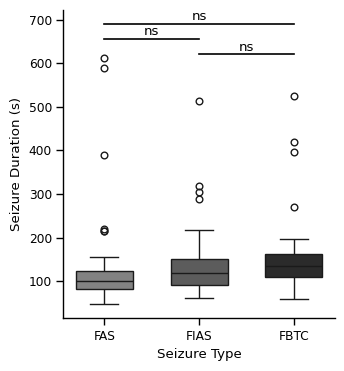

In [26]:
# Plot seizure duration by seizure type


with sns.plotting_context("paper", font_scale=1):
    plot_df = sz_duration_df.copy()
    plot_df = plot_df[plot_df.sz_type.isin(('FAS','FIAS','FBTC'))]

    fig, ax = plt.subplots()
    fig.set_size_inches(3.5,4)

    g = sns.boxplot(
        data=plot_df, 
        x='sz_type',
        y='sz_end',
        order=['FAS','FIAS','FBTC'],
        hue='sz_type',
        ax=ax,
        width=0.6,
        palette=sns.color_palette(palette='Greys_r')
    )

    for x1,x2,y in ([0,2,690],[0,1,655],[1,2,620]):
        plt.plot([x1,x2],[y,y],c='k',ls='-') # plot significance bars
        plt.text((x1+x2)/2, y+2, "ns", ha='center', va='bottom', c='k')

    g.axes.set_xlabel('Seizure Type')
    g.axes.set_ylabel('Seizure Duration (s)')
    sns.despine(fig=g.figure)

    plt.savefig("../viz/net_pdc_noNorm_sz_durations.pdf", bbox_inches='tight', format='pdf', transparent=True)
    plt.savefig("../viz/net_pdc_noNorm_sz_durations.svg", bbox_inches='tight', format='svg')

In [9]:
## In PDC by seizure type

# sz_len = 40
# xmin = -60
# xmax = sz_len + 60
# with sns.plotting_context("paper", font_scale=1.5):
#     with sns.color_palette("dark"):
#         plot_df = peri_stats_df # [peri_stats_df.patID == 'Epat03']
#         plot_df = plot_df[plot_df.win_sz_st_end > xmin]
#         plot_df = plot_df[plot_df.win_sz_st_end < xmax]

#         g = sns.relplot(
#             data=plot_df, 
#             row='sz_type',
#             row_order=['FAS','FIAS','FBTC'],
#             y='in_pdc',
#             x='win_sz_st_end',
#             hue='region',
#             aspect=4,
#             kind='line',
#             palette=COLOR_MAP
#         )
        
#         for ax, sz_type in zip(g.axes.flatten(), ['FAS','FIAS','FBTC']):
#             for i in (0,sz_len):
#                 ax.axvline(i,ls='--',c='k')
#                 ax.set_ylabel('In PDC')
#                 ax.set_title(sz_type)
        
#         g.axes[0][0].text(x=xmin//2, y=0.15, s='Pre-Ictal')
#         g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.15, s='Post-Ictal')
#         g.axes[-1][0].set_xlabel('Window')
#         g.figure.suptitle("Peri-Ictal In PDC",y=1.03)
        
#         plt.savefig("../viz/peri_in_pdc_noNorm_sztypes.pdf", format='pdf', transparent=True)


In [10]:
## Out PDC by seizure type

# sz_len = 40
# xmin = -60
# xmax = sz_len + 60
# with sns.plotting_context("paper", font_scale=1.5):
#     with sns.color_palette("dark"):
#         plot_df = peri_stats_df # [peri_stats_df.patID == 'Epat03']
#         plot_df = plot_df[plot_df.win_sz_st_end > xmin]
#         plot_df = plot_df[plot_df.win_sz_st_end < xmax]

#         g = sns.relplot(
#             data=plot_df, 
#             row='sz_type',
#             row_order=['FAS','FIAS','FBTC'],
#             y='out_pdc',
#             x='win_sz_st_end',
#             hue='region',
#             aspect=4,
#             kind='line',
#             palette=COLOR_MAP
#         )
        
#         for ax, sz_type in zip(g.axes.flatten(), ['FAS','FIAS','FBTC']):
#             for i in (0,sz_len):
#                 ax.axvline(i,ls='--',c='k')
#                 ax.set_ylabel('Out PDC')
#                 ax.set_title(sz_type)
        
#         g.axes[0][0].text(x=xmin//2, y=0.09, s='Pre-Ictal')
#         g.axes[0][0].text(x=((xmax-sz_len)//2)+sz_len, y=0.09, s='Post-Ictal')
#         g.axes[-1][0].set_xlabel('Window')
#         g.figure.suptitle("Peri-Ictal Out PDC",y=1.03)
        
#         plt.savefig("../viz/peri_out_pdc_noNorm_sztypes.pdf", format='pdf', transparent=True)
